# Week 47

In [1]:
try:
    import fysisk_biokemi
    print("Already installed")
except ImportError:
    %pip install -q "fysisk_biokemi[colab] @ git+https://github.com/au-mbg/fysisk-biokemi.git"

------------------------------------------------------------------------

## 1 A tricky protein binding.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
pd.set_option('display.max_rows', 6)

Here, we will analyse the results from an experiment used to quantify
affinity of a protein:lignd interaction. The data in
`binding_data_sq.xlsx` is in the form of saturation (theta) as a
function of the total ligand concentration L_tot. This is the type of
data you typically get from e.g. a fluorescence titration experiment.
Each measure-ment has been repeated three times.

Load the dataset as usual using the widget below

In [3]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

> **Tip**
>
> The command `display(df)` shows the dataframe that you’ve loaded.

In [4]:
df = uploader.get_dataframe()
display(df)

In [5]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('binding_data_sq') # Load from package for the solution so it doesn't require to interact.
display(df)

75 rows × 2 columns

#### (a) Convert to SI

Convert the ligand concentration to $\mathrm{M}$ and add it to the
dataframe as a new column named `'L_(m)'`.

You can use `display(df)` to check if you have been successful.

In [7]:
df['L_(M)'] = df['L_(uM)'] * 10**(-6)
display(df)

75 rows × 3 columns

#### (b) Plot

Make a scatter plot of the dataset and use the plot to estimate $K_D$.

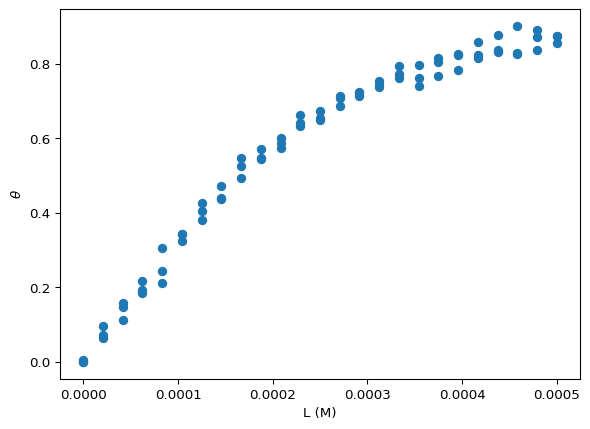

In [9]:
fig, ax = plt.subplots()

## Your task: Make a scatter plot (just points, no lines) of the data.  ##
ax.plot(df['L_(M)'], df['theta'], 'o')

## EXTRA: ##
## This adds x and y-axis labels. ##
ax.set_xlabel('L (M)')
ax.set_ylabel(r'$\theta$')
plt.show()

Put your estimate of $K_D$ in the cell below

In [10]:
## Your task: Assign your estimate of K_D to the variable below ##
K_D_estimate = 0.0001

#### (c) Fit and analyze.

Fit the data using the simple binding expression

$$
\theta = \frac{[L]}{[L] + K_D}
$$

Start by defining a function, called `simple_binding`, that calculates
this expression

In [12]:
## Your task: Define the function simple_binding that evaluates the equation ##
## from above. ##
def simple_binding(L, K_D):
    theta = L / (L + K_D)
    return theta

Then use that function to fit the data using `curve_fit`

In [14]:
## Your task: Set your estimate of K_D as the inital guess.
initial_guess = [K_D_estimate]

## Your task: Use curve_fit to find the fitted value of K_D
fitted_parameters, trash = curve_fit(simple_binding, df['L_(M)'], df['theta'], initial_guess)

## This extracts K_D and prints it ##
K_D_fit_simple = fitted_parameters[0]
print(K_D_fit_simple)

0.00013628483915769865

And evaluate the fit and plot it together with the dataset

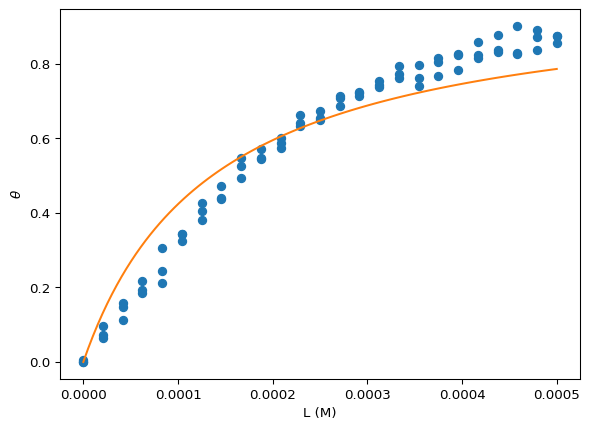

In [16]:
## Your task: Evaluate simple_binding using L_smooth and the value of K_D from your fit ##
L_smooth = np.linspace(0, 0.0005, 100)
theta_fit_simple = simple_binding(L_smooth, K_D_fit_simple)

fig, ax = plt.subplots()
## Your task: Plot the fit as line plot and the data as a scatter plot. ##
ax.plot(df['L_(M)'], df['theta'], 'o')
ax.plot(L_smooth, theta_fit_simple)

## EXTRA: 
## Labels for the axis.
ax.set_xlabel('L (M)')
ax.set_ylabel(r'$\theta$')
plt.show()

Is it a good fit?

#### (d) Residuals

To get a more quantitative view of the quality of the fit calculate
residuals

In [18]:
theta_model = simple_binding(df['L_(M)'], K_D_fit_simple)
residuals_simple = df['theta'] - theta_model

And plot them versus the measured $\mathrm{[L]}$

Text(0, 0.5, 'Residual')

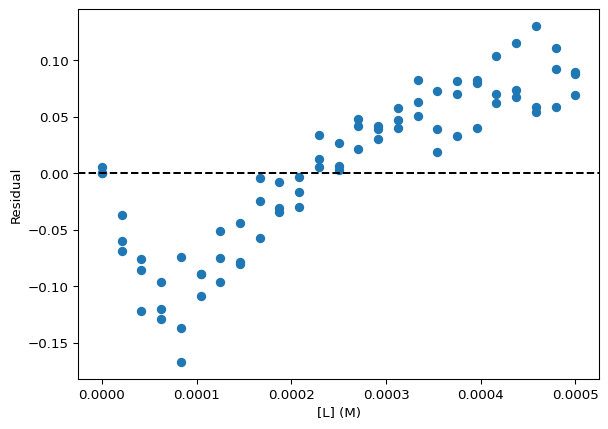

In [20]:
fig, ax = plt.subplots()

## Your task: Make a plot with residuals on the y-axis and L on the x-axis ##
ax.plot(df['L_(M)'], residuals_simple, 'o')

## This makes a horizontal line through 0 ##
ax.axhline(0, color='black', linestyle='--')

## EXTRA
## Adds axis labels. 
ax.set_xlabel('[L] (M)')
ax.set_ylabel('Residual')

Are the residuals randomly distributed around zero? What does this tell
you about the quality of the fit?

#### (e) Formulate a hypothesis

The protein concentration in the above titrations was 250 uM. Formulate
a hypothesis for why the fit fails.

#### (f) Choosing a better model

Next, we will try a fitting model that explicitly considers the
concentration of the protein being titrated. This is known as the
quadratic binding equation $$
\begin{aligned}
\theta &= \frac{K_D + [P_{tot}] + [L_{tot}]}{2[P_{tot}]} - \sqrt{\left(\frac{K_D + [P_{tot}] + [L_{tot}]}{2[P_{tot}]}\right)^2 - \frac{[L_{tot}]}{[P_{tot}]}} \\
\end{aligned}
$$

The value of $[P_{tot}]$ is $250 \ \mu\mathrm{M}$.

Start by implementing the expression as a Python function - remember
that you need to be careful with parentheses with a function like this.

In [23]:
def quadratic_binding(L, K_D):    
    ## Your task: Set the protein concentration in appropriate units. ##
    P_tot = 250 * 10**(-6)

    ## Your task: Implement the quadratic binding equation ## 
    ## Be careful with parentheses! ##
    theta = (K_D + P_tot + L) / (2 * P_tot) - np.sqrt(((K_D + P_tot + L) / (2 * P_tot))**2 - L / P_tot)
    return theta

print(f"{quadratic_binding(100, 138.09) = :.3f}") # Should give 0.420

quadratic_binding(100, 138.09) = 0.420

And now make a fit using this expression

In [25]:
## Your task: Make a fit using the quadratic binding equation. ##
fitted_parameters, trash = curve_fit(quadratic_binding, df['L_(M)'], df['theta'])

## Extratcs and prints K_D ##
K_D_fit_quad = fitted_parameters[0]
print(K_D_fit_quad)

4.214239381928562e-05

The cell below makes a figure of the data and the residuals for each
fit. You are not expected to understand every line of code – the figure
is mainly to aid you interpretation of the data and show case how you
can make beautiful figures from you own data later on.

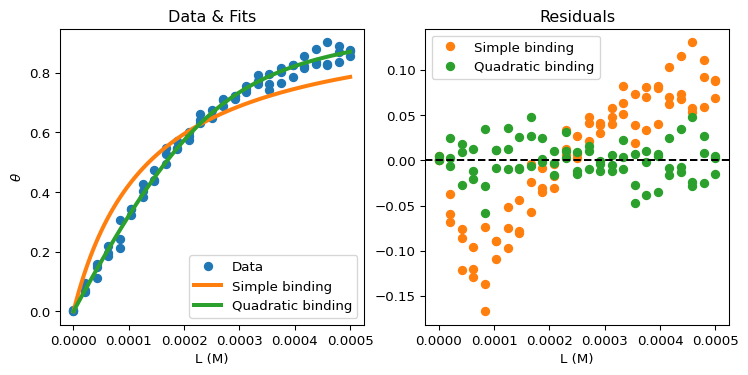

In [27]:
theta_fit_quad = quadratic_binding(L_smooth, K_D_fit_quad)
residuals_quad = df['theta'] - quadratic_binding(df['L_(M)'], K_D_fit_quad)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Data & Fit
ax = axes[0]
ax.plot(df['L_(M)'], df['theta'], 'o', label='Data')
ax.plot(L_smooth, theta_fit_simple, label='Simple binding', linewidth=3)
ax.plot(L_smooth, theta_fit_quad, label='Quadratic binding', linewidth=3)
ax.set_xlabel('L (M)')
ax.set_ylabel(r'$\theta$')
ax.set_title('Data & Fits')
ax.legend()

# Residuals
ax = axes[1]
ax.plot(df['L_(M)'], residuals_simple, 'o', color='C1', label='Simple binding')
ax.plot(df['L_(M)'], residuals_quad, 'o', color='C2', label='Quadratic binding')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Residuals')
ax.set_xlabel('L (M)')
ax.legend()

plt.show()

#### (g) Analyze

Consider the following questions:

-   How does the quadratic binding expression fit the data?
-   Whats the difference in how the residuals are distributed?
-   What is the biochemical situation that makes quadratic expression
    necessary?

------------------------------------------------------------------------

## 2 Determination of reaction orders.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
pd.set_option('display.max_rows', 6)

You have carried out a kinetic experiment investigating the turnover of
two metabolites, A1 and A2, in a cell lysate. For each metabolite, you
have measured the concentration of the compound as a function of time
using UV-Vis spectroscopy aiming to determine the reaction order, and
thus deduce something about the reaction mechanism by which they are
processed. The date from this experiment is found in
`reaction-orders.xlsx`.

#### (a) Load the dataset

Load the dataset `reaction-orders.xlsx` using the widget below

In [30]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [31]:
df = uploader.get_dataframe()
display(df)

In [32]:
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('reaction_order_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

51 rows × 3 columns

#### (b) SI units.

Add two new columns with the concentrations given in M.

In [34]:
df['A1_M'] = df['A1_uM'] * 10**(-6)
df['A2_M'] = df['A2_uM'] * 10**(-6)
display(df)

51 rows × 5 columns

#### (c) Plotting

For each reactant make a plot of the concentration versus time.

Text(0, 0.5, 'Concentration')

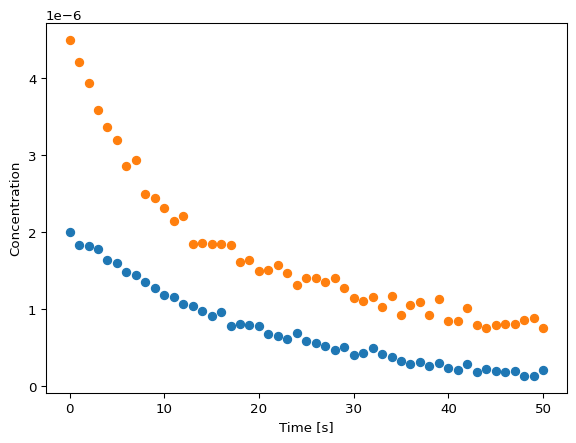

In [36]:
fig, ax = plt.subplots() 

## Your task: Make plots of concentration (y) versus time (x). ##
## Hint: ax.plot(x_data, y_data, 'o') to make a scatter plot. ##
ax.plot(df['Time_s'], df['A1_M'], 'o')
ax.plot(df['Time_s'], df['A2_M'], 'o')

## EXTRA: Customization of axis labels ##
ax.set_xlabel('Time [s]')
ax.set_ylabel('Concentration')

#### (d) Model as N’th-order reaction

We can start by modelling both reactions as zeroths order. We will
consider both the the rate constant $k$ and the concentration at time
$t = 0$ parameters.

In [38]:
def zeroth_order(t, k, A0):
    ## Your task: Implement the zeroth order rate equation ##
    concentration = A0 - k*t
    return concentration

def first_order(t, k, A0):
    ## Your task: Implement the first order rate equation ##
    return A0 * np.exp(-k*t)

def second_order(t, k, A0):
    ## Your task: Implement the second order rate equation ##
    return A0 / (1 + 2*k*t*A0)

Then we can make a fit to measurements of each reactant.

In [40]:
## Your task: Pick a rate equation and assign it to the variable rate_equation
## You can change this to first_order or second_order
## Do not call the function - so no (...) just assign it to the variable.
rate_equation = zeroth_order

## Your task: Make a fit of the A1_M data with 'rate_equation'.
fitted_parameters_A1, trash = curve_fit(rate_equation, df['Time_s'], df['A1_M'])    
k_A1_fit = fitted_parameters_A1[0]
A1_0_fit = fitted_parameters_A1[1]

## Your task: Make a fit of the A2_M with 'rate_equation'.
fitted_parameters_A2, trash = curve_fit(rate_equation, df['Time_s'], df['A2_M'])
k_A2_fit = fitted_parameters_A2[0]
A2_0_fit = fitted_parameters_A2[1]

## Prints the found parameters
print(k_A1_fit)
print(A1_0_fit)

print(k_A2_fit)
print(A2_0_fit)

3.390184293164445e-08
1.5887604659704164e-06
5.786947687397643e-08
3.148604267116672e-06

Now that we fitted the data using one of the rate equations, we can plot
to see how well it fits

Text(0, 0.5, 'Concentration')

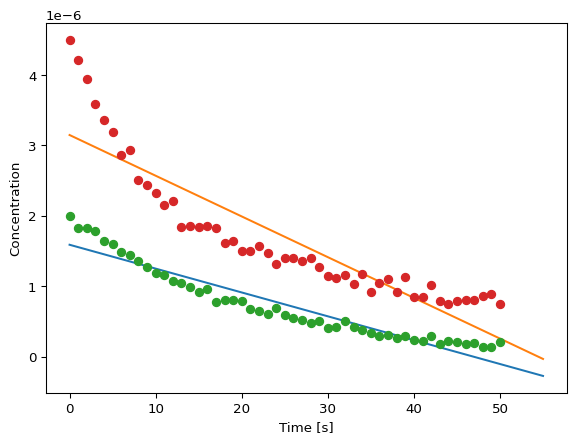

In [42]:
fig, ax = plt.subplots() 

t_smooth = np.linspace(0, 55)
A1_fit = rate_equation(t_smooth, k_A1_fit, A1_0_fit)
A2_fit = rate_equation(t_smooth, k_A2_fit, A2_0_fit)

## Your task: Plot the fits 
ax.plot(t_smooth, A1_fit)
ax.plot(t_smooth, A2_fit)

## Plots the data ##
ax.plot(df['Time_s'], df['A1_M'], 'o')
ax.plot(df['Time_s'], df['A2_M'], 'o')

## EXTRA: Customization of axis labels ##
ax.set_xlabel('Time [s]')
ax.set_ylabel('Concentration')

Once you’ve finished the fitting with one of the rate equations you can
go back and change the `rate_equation` variable to try one of the
others.

#### (f) Determining reaction orders

The cell below makes a plot for each rate law in the same panel using
your defined rate equations.

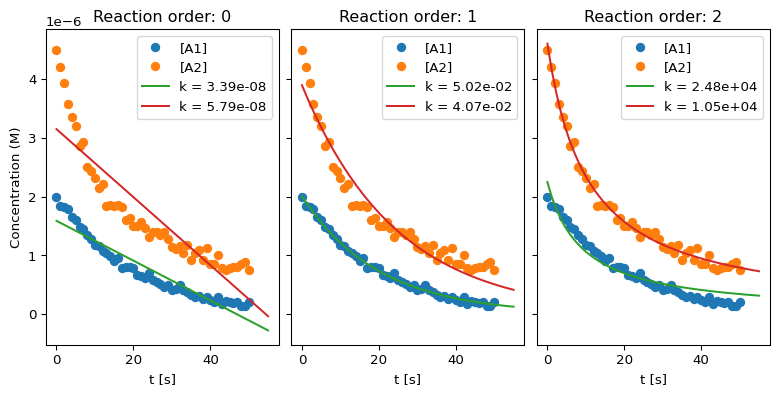

In [44]:
from fysisk_biokemi.utils.deter_reacti_orders import make_plot
rate_laws = {0: zeroth_order, 1: first_order, 2: second_order}
make_plot(df, rate_laws)

Based on this plot;

1.  What is the reaction order for \[A1\]?
2.  What is the unit of the rate constant for \[A1\]?
3.  What is the reaction order for \[A2\]?
4.  What is the unit of the rate constant for \[A2\]?

#### (e) Reaction mechanism

What does the above tell you about the reaction mechanism whereby the
two compounds disappear from the lysate?

------------------------------------------------------------------------

## 3 Analysis of a reversible reaction

In [47]:
import matplotlib.pyplot as plt
import numpy as np

Consider the following reaction

$$
A \underset{k_{2}}{\stackrel{k_1}{\rightleftharpoons}} B
$$

The magnitudes of the rate constants are $k_1 = 10 \ \mathrm{s}^{-1}$
and $k_2 = 1 \ \mathrm{s}^{-1}$.

#### (a) Reaction order

What is the reaction order in each direction?

#### (b) Derive equilibrium constant

Show mathematically how the equilibrium constant $K_{\mathrm{eq}}$ is
given by the ratio between the two rate constants.

#### (c) Calculate $K_{\mathrm{eq}}$

In [51]:
## Your task: Assign known values & calculate the equilibrium constant.
k1 = 10 
k2 = 1
K_eq = k1 / k2
print(K_eq)

10.0

#### (d) Equilibrium concentrations

Calculate the concentrations of A and B at equilibrium,
$[\mathrm{A}]_{\mathrm{eq}}$ and $[\mathrm{B}]_\mathrm{eq}$, if
$[\mathrm{A}]_0 = 10^{-3} \text{M}$

In [53]:
A0 = 10**(-3)
A_eq = (k2 * A0) / (k1 + k2)
B_eq = (k1 * A0) / (k1 + k2)
print(A_eq)
print(B_eq)

9.090909090909092e-05
0.0009090909090909091

#### (e) Initial rate of formation

If $[\mathrm{A}]_0 = 10^{-3} \text{M}$ and
$[\mathrm{B}]_0 = 0 \text{M}$, calculate the initial rate of formation
of B.

In [55]:
## Your task: Calculate initial rate of formation of B
r_fwd = A0 * k1
print(r_fwd)

0.01

#### (f) Time-dependence

![](https://raw.githubusercontent.com/au-mbg/fysisk-biokemi/refs/heads/main/course/lessons/figures/week_48/reversible_reaction.png)

We now want to calculate and plot the time-dependent concentrations
using the above equations.

In the cell below finish the implementation of the function `A_time`
that calculates the concentration \[A\] as a function of time.

In [57]:
## Your task: Implement the function to calculate the time dependent concentration.
## Be careful with parentheses.
def A_time(t, A0, k_f, k_b):
    return (k_b + k_f * np.exp(-(k_f+k_b)*t)) / (k_f + k_b) * A0


test = A_time(1, 1, 1, 1)
print(test) # This should 0.567...

0.5676676416183064

And then we can use that function to calculate and plot the
concentrations as a function of time. As you have seen above, the
reaction is pretty fast, so we will just focus on the first second

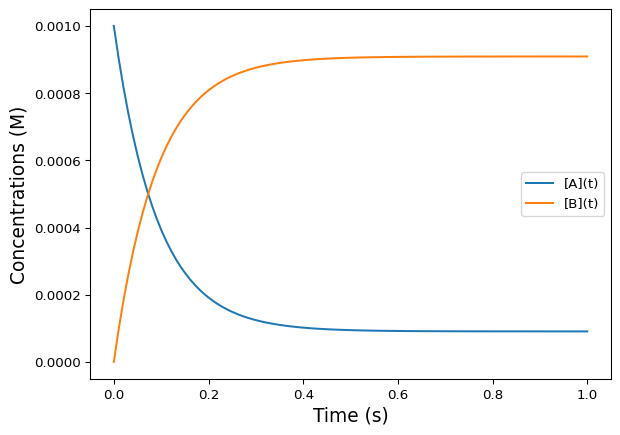

In [59]:
fig, ax = plt.subplots()
t = np.linspace(0, 1, 100)

## Your task: Calculate [A](t) and [B](t) ##
At = A_time(t, A0, k1, k2)
Bt = A0 - At

## Plots the concentrations versus time.
ax.plot(t, At, label='[A](t)')
ax.plot(t, Bt, label='[B](t)')

## EXTRA: Sets x and y-axis labels. 
ax.set_ylabel('Concentrations (M)', fontsize=14)
ax.set_xlabel('Time (s)', fontsize=14)
ax.legend()

------------------------------------------------------------------------

## 4 Determination of reaction order and activation energy

In [60]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
pd.set_option('display.max_rows', 6)

The irreversible isomerization of compound A to compound B results in a
decreasing absorbance. The isomerization was followed in a time course
at two different temperatures (T1 = 25 °C and T2 = 40 °C). The
absorbance ($\epsilon$ = 16700 $\mathrm{cm}^{-1} \mathrm{M}^{-1}$) was
used to calculate the concentration of compound A in a spectrophotometer
with a pathlength of 1 cm. The obtained dataset is given in the file
`deter-reacti-order-activ.csv`.

#### (a) Temperatures

What are the two temperatures in Kelvin? Set them as varilabes in the
cell below.

In [62]:
## Your task: Convert the temperatures to K and assign to the variables:
T1 = 25 + 273.15
T2 = 40 + 273.15

#### (b) Load the dataset

Load the dataset using the widget below

In [63]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [64]:
df = uploader.get_dataframe()
display(df)

In [65]:
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('reaction_order_activation_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

26 rows × 3 columns

#### (c) SI Units

Calculate the concentration of A at each timepoint in SI units, by
adding new columns to the `DataFrame`.

In [67]:
## Your task: Assign known values ##
extinction_coeff = 16700 
L = 1 # Path length

## Calculate concentrations using the variables above and the data in the dataframe ##
df['[A]_(M)_25C'] = df['Abs(t)_25C'] / (extinction_coeff * L)
df['[A]_(M)_40C'] = df['Abs(t)_40C'] / (extinction_coeff * L)
display(df)

26 rows × 5 columns

#### (d) Plot the data

We will be resuing the plot, so we will put the code for it in a
function.

In [69]:
def plot_dataframe(ax, df):
    # Extract from dataframe
    t = df['t_(s)']
    A_25 = df['[A]_(M)_25C']
    A_40 = df['[A]_(M)_40C']

    # First subfigure: t vs [A]
    ax.plot(t, A_25, 'o', label='[A]_25C')
    ax.plot(t, A_40, 'o', label='[A]_40C')
    ax.set_xlabel('t (s)')
    ax.set_ylabel('[A] (M)')
    ax.legend()

You can run this next cell to see your plot and adjust as neccesarry.

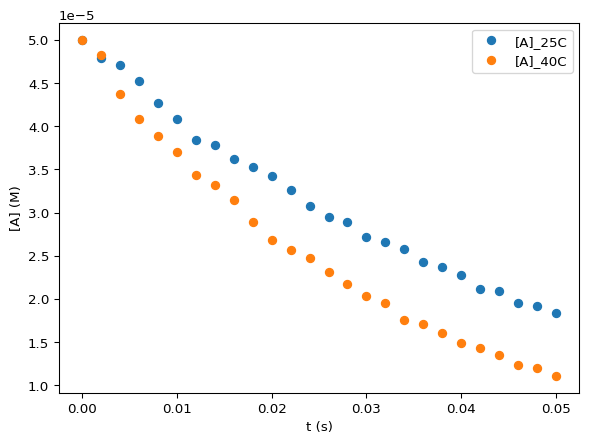

In [70]:
fig, ax = plt.subplots()
plot_dataframe(ax, df)

#### (e) Determine reaction order

In the exercise on “Determination of reaction orders” we saw how we can
fit to the expressions for the integrated rate laws to determine the
reaction order.

In that exercise we wrote the functions in the next two cells, we will
reuse them here

In [71]:
def zeroth_order(t, k, A0):
    return A0 - k*t

def first_order(t, k, A0):
    return A0 * np.exp(-k*t)

def second_order(t, k, A0):
    return A0 / (1 + 2*k*t*A0)

rate_laws = {0: zeroth_order, 1: first_order, 2:second_order}

In [72]:
from scipy.optimize import curve_fit

def make_fit(x_data, y_data, x_eval, A0, order):
    func = lambda t, k: rate_laws[order](t, k, A0)
    popt, pcov = curve_fit(func, x_data, y_data)

    # Evaluate fit at new points
    k = popt[0]
    y_fit_new = func(x_eval, k)
    
    # Evaluate fit at data-points to calculate residuals
    y_fit_data = func(x_data, k)
    residuals = y_data - y_fit_data

    return k, y_fit_new, residuals

Now we need to set a few things before we can do the fitting

In [74]:
t = df['t_(s)']
A_25 = df['[A]_(M)_25C']
A_40 = df['[A]_(M)_40C']
A0_25= A_25[0]
A0_40 = A_40[0]

> **Tip**
>
> You’ve already calculated the initial concentration, it is contained
> in the `DataFrame`.

Now we can use our plotting and fitting functions to analyze the data

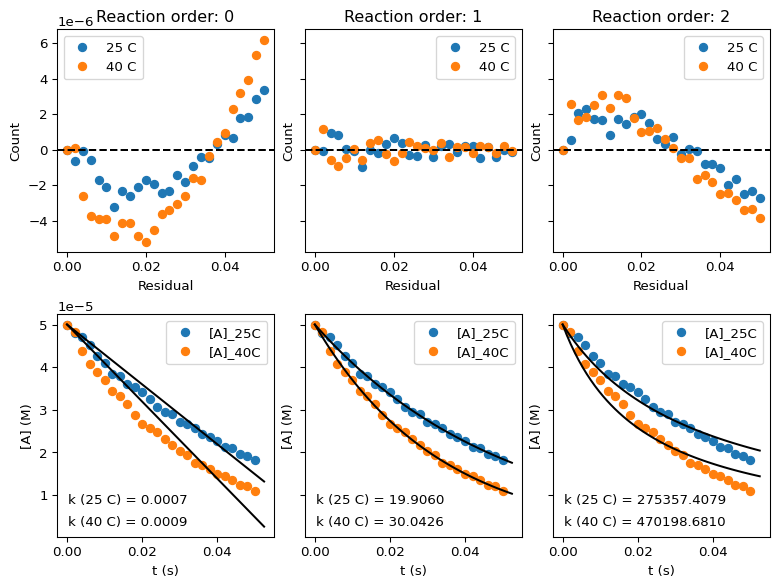

In [76]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharey='row', layout='constrained')

for ax in axes.T:
    plot_dataframe(ax[1], df)

orders = [0, 1, 2]
t_eval = np.linspace(0, t.max()*1.05)

for ax_col, order in zip(axes.T, orders):
    # Calculate the fits
    k25, y_fit_25, residuals_25 = make_fit(t, A_25, t_eval, A0_25, order)
    k40, y_fit_40, residuals_40 = make_fit(t, A_40, t_eval, A0_40, order)

    # Plot the fits
    ax = ax_col[1]
    ax.plot(t_eval, y_fit_25, color='k')
    ax.plot(t_eval, y_fit_40, color='k')
    ax.text(0.05, 0.15, f'k (25 C) = {k25:.4f}', transform=ax.transAxes)
    ax.text(0.05, 0.05, f'k (40 C) = {k40:.4f}', transform=ax.transAxes)

    ax.legend()

    # Plot the residuals
    ax = ax_col[0]
    ax.plot(t, residuals_25, 'o', color='C0', label='25 C')
    ax.plot(t, residuals_40, 'o', color='C1', label='40 C')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('Residual')    
    ax.set_ylabel('Count')
    ax.legend()

    ax.set_title(f'Reaction order: {order}')

Based on these plots

-   What do you think the reaction order of the reaction is?
-   What’s the rate constant?
-   What the unit of the rate constant?

#### (f) Half-life

What is the half-life of the reaction at these temperatures and is it
constant through-out the reaction?

In [77]:
... 

#### (g) Activation energy

With the assumption that the Arrhenius constant A and the activation
energy are temperature independent in the interval measured, use the
Arrhenius equation to calculate the activation energy of the
isomerization of the compound A.

Perform the calculation in the cell below.

In [78]:
...

------------------------------------------------------------------------

## 5 The pH effect on an active site histidine residue

Assume that a compound R can react with the unprotonated form of
Histidine, $\text{His}$, to form a covalent reaction product,
$\text{P}$: $$
\text{His} + \text{R} \rightarrow \text{P}
$$

The protonated form of Histidine, $\text{HisH}^+$, is in equilibrium
with $\text{His}$:

$$
\text{HisH}^+ \rightleftharpoons \text{His} + \text{H}^+
$$

The pKa value for this acid-base equilibrium is 6.0. Further assume that
the total concentration of Histidine, is

$$
[\text{HisH}^+] + [\text{His}] = 10^{-3} \ \text{M}
$$

#### (a) Percentage unprotonated

Using the Henderson-Hasselbach equation, calculate the percentage of
unprotonated Histidine, $\text{His}$, at pH 6.0.

In [80]:
## Your set known values. ##
pKa = 6.0
pH = 6.0

## Your task: percentage of unprotonated 
## It may be useful to do an intermediate calculation..
ratio = 10 ** (pH - pKa) # The intermediate
percentage_unprotonated = 1 / (1 + ratio) * 100

## Prints
print(percentage_unprotonated)

50.0

#### (b) Concentration

Calculate $[\text{His}]$ at pH 6

In [82]:
## Your task: Assign known value and calculate [His]
total_conc = 10**(-3)
his_conc = total_conc * percentage_unprotonated
print(his_conc)

0.05

#### (c) Reaction order

The reaction equation for the reaction between $\text{His}$ and
$\text{R}$ is

$$
v = - \frac{d[\text{His}]}{dt} = k \cdot [\text{His}] \cdot [\text{R}]
$$

What’s the reaction order?

#### (d) High concentrations

If $[\text{R}]$ is much higher than $[\text{His}]$, what can then be
concluded regarding the order of the reaction?

#### (e) New rate constant

Show how a new rate constant, $k'$, can be defined in these conditions.
How does $k'$ depend on $\text{R}$?

#### (f) SI Units

At pH 6.0 the reaction rate $v = 1 \ \text{mM}\cdot \text{s}^{-1}$.

Convert the reaction rate to SI-units given in
$\text{M}\cdot \text{s}^{-1}$.

In [87]:
# Your task: Calculate v in SI units M / s
reaction_rate = 1 * 10**(-3) # Units: M / s
print(reaction_rate)

0.001

#### (g) Calculate the rate constant

Use the concentration of $[\text{His}]$ at pH 6 calculated in question
(b), the reaction rate from (f) and constant
$[\text{R}] = 0.2 \ \text{M}$ to calculate the rate constant $k$.

In [89]:
## Your task: Set known value and calculate k ##
## Hint: You can use the his_conc variable ##
R_conc = 0.2
k = reaction_rate / (R_conc * his_conc)
print(k)

0.09999999999999998

------------------------------------------------------------------------

## 6 Design of an enzyme kinetics experiment

In [90]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
pd.set_option('display.max_rows', 6)

In the Excel document `design-enzyme-kineti-exper.xlsx` you will find a
data set in which an enzyme catalyzed formation of product P, with
varying start concentration of substrates, \[S\], was followed over
time. The product absorbs light at a specific wavelength with an
extinction coefficient of 0.068 $\mu\text{M}^{-1}\cdot \text{cm}^{-1}$,
and the absorbance was measured in a light path of 1 cm throughout the
time course.

You can load the dataset using the cells below;

In [91]:
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [92]:
df = uploader.get_dataframe()
display(df)

In [93]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('design-enzyme-kineti-exper.xlsx') # Load from package for the solution so it doesn't require to interact.
display(df)

21 rows × 10 columns

The headers, like `Abs_S1` refer to the substrate concentration so `S1`
means a substrate concentration of 1 $\mu\text{M}$.

#### (a) Connvert extinction coefficient to SI.

Convert the extinction coefficient to units given in
$\text{M}^{-1}\cdot \text{cm}^{-1}$ and assign it to a variable. Also
assign the light path length to a variable.

In [95]:
## Assign known values in SI units.
ext_coeff = 0.068 / 10**(-6) # 1/(M cm)
l = 1 # cm

#### (b) Calculate concentrations

Using Lambert-Beers law, calculate the concentration of product, \[P\],
in M for each time series.

> **Loops**
>
> Loops are one of the most useful parts of programming, loops allows us
> to repeat an operation on many different elements. This allows us to
> not have to repeat code many times, making it simpler to understand
> and less prone to error - and at the same time more flexible.
>
> A common type of loop in Python is the `for` loop, which does
> something `for` every item it is told to consider. The syntax of a
> `for`-loop is like so:
>
> ``` python
> total = 0
> for count in [1, 2, 3, 4, 5]:
>     print(f"I have {count} apples.")
> ```
>
> Which will print
>
>     I have 1 apples
>     I have 2 apples
>     I have 3 apples
>     I have 4 apples
>     I have 5 apples
>
> So the `for`-loop did the operation of printing a string for each
> value of `count`.
>
> When working with a `DataFrame` like in this exercise, we may for
> example want to do something `for` each column, one way of doing that
> is to loop over the column names, say we want we have a `DataFrame`
> `df` with columns named `"col1", "col2", "col3"` we can loop over that
> as
>
> ``` python
> for name in ['col1', 'col2', 'col3']
>     df[name] = ... # Some operation
> ```

The cell below setups a loop calculate the concentrations for each of
these current columns in the dataframe.

In [97]:
substrate_concentrations = [1, 2, 4, 8, 16, 32, 64, 128, 256]
for s in substrate_concentrations:
    abs_col_name = f'Abs_S{s}' # This creates a string where the value of 's' is put instead of "{s}"".
    conc_col_name = f'C_S{s}' # Same type string creation 
    df[conc_col_name] = df[abs_col_name] / (ext_coeff * l)
    print(s, abs_col_name, conc_col_name)

1 Abs_S1 C_S1
2 Abs_S2 C_S2
4 Abs_S4 C_S4
8 Abs_S8 C_S8
16 Abs_S16 C_S16
32 Abs_S32 C_S32
64 Abs_S64 C_S64
128 Abs_S128 C_S128
256 Abs_S256 C_S256

And we can check that the columns we expect have been added to the
`DataFrame`.

In [99]:
display(df)

21 rows × 19 columns

#### (c) Plot

Plot \[P\] as a function of time for all experiments in one single
graph.

Here it is again very useful to use a `for`-loop

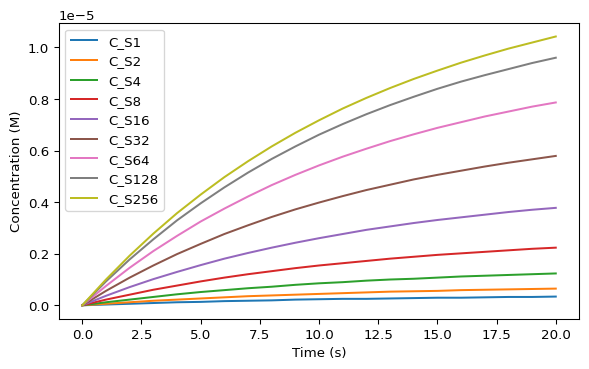

In [100]:
fig, ax = plt.subplots(figsize=(7, 4))

x_axis = df['time_(s)']
substrate_concentrations = [1, 2, 4, 8, 16, 32, 64, 128, 256]
for s in substrate_concentrations:
    conc_col_name = f'C_S{s}'
    y_axis = df[conc_col_name]

    ax.plot(x_axis, y_axis, label=conc_col_name)    

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Concentration (M)')


ax.legend()    

#### (d) Extracting $V_0$.

We want to use Python to determine $V_0$ for each concentration of $S$,
in order to create a table of $V_0$ vs $[S]$. To do so we will fit
linear functions to the initial parts of the curves, as the slope of
these is then $V_0$.

Start by defining a linear function;

In [102]:
def linear_func(x, a, b):
    return a * x + b

As mentioned we want to to get the slope in the initial part of the
reaction, where the curves are approximately linear. To do so we need to
fit not on all the data-points but only some of them.

In the cell below `n_points` determines the number of data-points used
for the linear fit. Use this cell to find an appropriate value of
`n_points`.

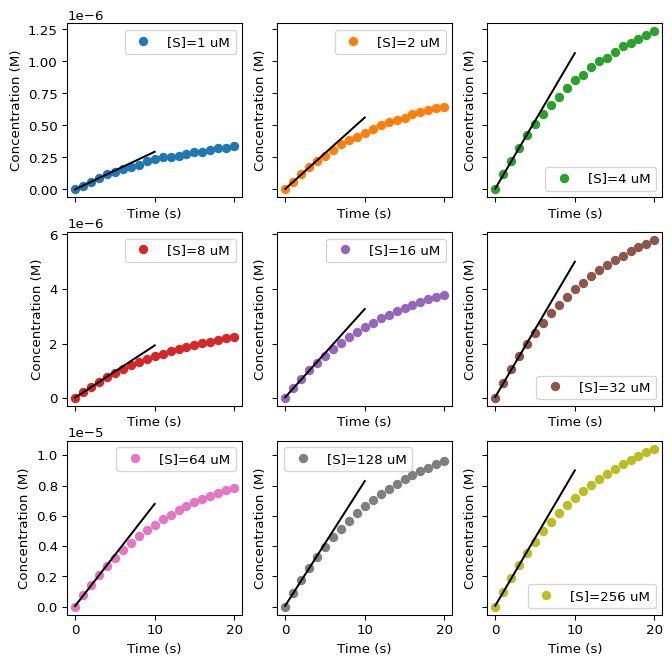

In [104]:
# The number of points used to make the fit
n_points = 5

# Variables to store calculated values.
slopes = []
concentrations = []

fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey='row') # We make the figure while also finding the slopes.
for i, (s, ax) in enumerate(zip(substrate_concentrations, axes.flatten())): # Don't worry about the details of this.

    # Make the
    conc_col_name = f'C_S{s}'
    x_data = df['time_(s)'][:n_points]
    y_data = df[conc_col_name][:n_points]
    popt, pcov = curve_fit(linear_func, x_data, y_data)

    # Plot the data
    ax.plot(df['time_(s)'], df[conc_col_name], 'o', color=f'C{i}', label=f'[S]={s} uM')

    # Plot the fit
    t_smooth = np.linspace(0, 10, 10)
    ax.plot(t_smooth, linear_func(t_smooth, *popt), color='black', linestyle='-')

    # Customize
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Concentration (M)')
    ax.legend()

    # Store calculated slopes and concentrations, concentration converted to molar.
    slopes.append(popt[0])
    concentrations.append(s * 10**(-6))

Once you’re satisfied with the fit you can display the collected slopes
with the cell below

In [105]:
V0_df = pd.DataFrame({'[S]_(M)': concentrations, 'V0_(M/s)': slopes})
display(V0_df)

9 rows × 2 columns

#### (e) Understanding of $V_0$

Why is it important to use $V_0$ rather than $V$ at a later time point
when creating the Michaelis-Menten plot?

#### (f) Plotting again.

Plot $V_0$ against substrate concentration and estimate $k_{cat}$ and
$K_M$ visually (remember units)

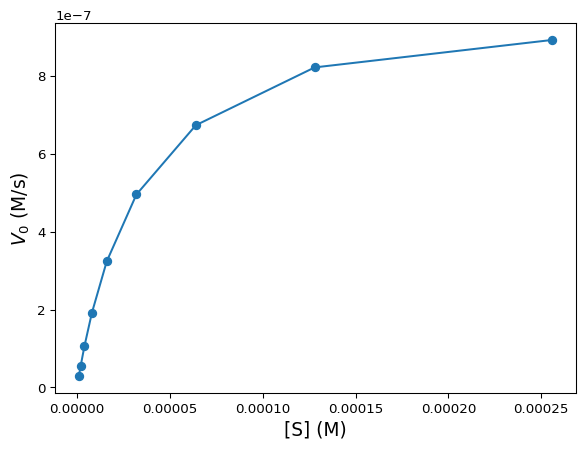

In [107]:
fig, ax = plt.subplots()
ax.plot(V0_df['[S]_(M)'], V0_df['V0_(M/s)'], '-o')

ax.set_xlabel('[S] (M)', fontsize=14)
ax.set_ylabel('$V_0$ (M/s)', fontsize=14);

------------------------------------------------------------------------

## 7 Analysis of a data set obeying Michaelis-Menten kinetics

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
pd.set_option('display.max_rows', 6)

The kinetics for an enzyme were investigated using the absorbance of the
product to calculate the initial velocities for a range of different
initial concentrations of the substrate. The data given in the dataset
`analys-data-set-obeyin.xlsx` was obtained. Use these data to answer the
following questions.

In [110]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [111]:
df = uploader.get_dataframe()
display(df)

In [112]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('week49_2') # Load from package for the solution so it doesn't require to interact.
display(df)

39 rows × 2 columns

#### (a) SI Units

Convert the concentrations of substrate and the velocities to the SI
units $\text{M}$ and $\text{M}\cdot\text{s}^{-1}$, respectively.

In [114]:
df['[S]_(M)'] = df['[S]_(mM)'] * 10**(-3)
df['V0_(M/s)'] = df['V0_(uM/s)'] * 10**(-6)
display(df)

39 rows × 4 columns

#### (b) Plot & estimate

Plot the initial velocities, $V_0$, as a function of substrate
concentrations, $[S]$. Estimate $K_M$ and $V_\mathrm{max}$ from this
plot.

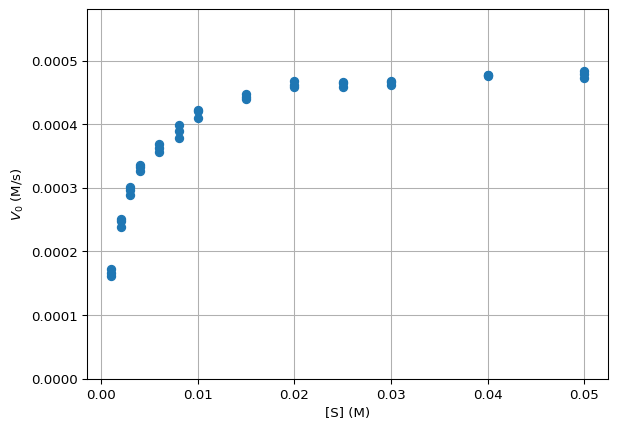

In [116]:
fig, ax = plt.subplots()
ax.plot(df['[S]_(M)'], df['V0_(M/s)'], 'o')
ax.set_xlabel('[S] (M)')
ax.set_ylabel('$V_0$ (M/s)')
ax.grid('on')
ax.set_ylim(0, df['V0_(M/s)'].max()*1.2)

#### (c) Fit

Now we want to fit using the Michaelis-Menten equation, as per usual
when the task is fitting we have to define the function we are fitting
with

In [118]:
def michaelis_menten(S, Vmax, Km):
    return (Vmax * S) / (Km + S)

> **Caution**
>
> This is one of those places were parentheses are crucial.

And then we can follow our usual procedure to make the fit

In [120]:
x_data = df['[S]_(M)']
y_data = df['V0_(M/s)']

popt, pcov = curve_fit(michaelis_menten, x_data, y_data)
Vmax, Km = popt

print(f"{Vmax = :.4f}")
print(f"{Km = :.4f}")

Vmax = 0.0005
Km = 0.0021

How do these values compare to your estimate?

#### (d) Enzyme concentration

The $k_{cat}$ of the enzyme was determined to be
$20000 \ \text{s}^{-1}$. Calculate, in the cell below, the concentration
of the enzyme used in the assay.

In [122]:
kcat = 20000
enzyme_concentration = Vmax / kcat 
print(f'Enzyme concentration: {enzyme_concentration:.3e} M')

Enzyme concentration: 2.504e-08 M

------------------------------------------------------------------------

## 8 Lab Exercise Analysis: Michaelis Menten

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In the “Introduction to the Molecules of Life”-course you performed an
experiment where you measured absorption for different substrate
concentrations as a function of time. The experiment was done with
p-nitrophenylphosphat as the substrate and turns into p-nitrophenol when
the enzyme (alkaline phosphatase) acts on it.

Load your dataset using the widget below

In [124]:
import numpy as np
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [125]:
df = uploader.get_dataframe()
display(df)

In [126]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('kinetics_LØ') # Load from package for the solution so it doesn't require to interact.
display(df)

19 rows × 9 columns

#### (a) Units

The measured absorbances are unitless, they are the log of the ratio
between the incoming light intensity and the transmitted light
intensity. We would like to work with concentrations instead, so we need
to convert the absorbance to concentration. The conversion is done using
Lambert-Beer’s law.

The extinction coefficient of the product p-nitrophenol is
$\varepsilon = 18000 \, \text{M}^{-1} \text{cm}^{-1}$ at
$405 \ \text{nm}$ and the path length of the cuvette is
$l = 1\, \text{cm}$. We will construct a new `DataFrame` with
concentrations

We will start by definining a function `lambert_beers` to calculate the
concentrations

In [128]:
def lambert_beers(absorbance):
    L = 1 # cm
    ext_coeff = 18000 # 1 / (M cm)
    conc = absorbance / (L * ext_coeff) # M 
    return conc

The next cell makes a new `DataFrame` by applying the lambert_beers
function to every column in the original

In [130]:
data = {
    'time': df['time'],
    'S_0.8_mM': lambert_beers(df['0.8']),
    'S_0.4_mM': lambert_beers(df['0.4']),
    'S_0.2_mM': lambert_beers(df['0.2']),
    'S_0.12_mM': lambert_beers(df['0.12']),
    'S_0.05_mM': lambert_beers(df['0.05']),
    'S_0.02_mM': lambert_beers(df['0.02']),
    'S_0.01_mM': lambert_beers(df['0.01']),
    'S_0.003_mM': lambert_beers(df['0.003']),
}

df = pd.DataFrame(data)
display(df)

19 rows × 9 columns

#### (b) Plot

Now lets plot the data. Plot each column seperately as a function of
time.

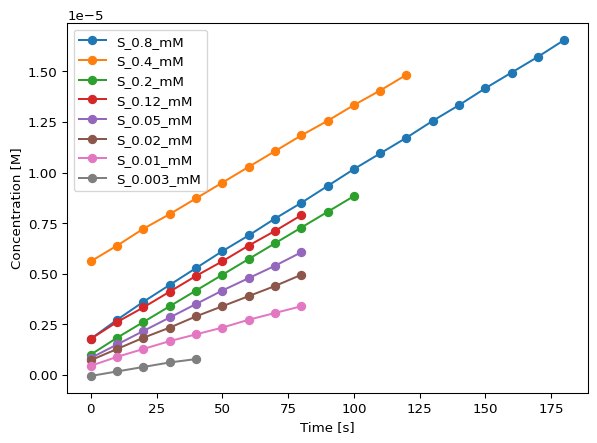

In [132]:
fig, ax = plt.subplots()

for key in df.keys():
    if key != 'time':
        ax.plot(df['time'], df[key], '-o', label=key)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Concentration [M]')
ax.legend()
plt.show()

#### (c) Finding the slopes

In order to apply the Michaelis Menten equation we need the slopes of
this curves as that is the reaction velocity $V_0$, luckily we have
learned how to make fit! So we make a fit to the linear function to
determine the slope $a$ in, $$
y(x) = a x + b
$$ As always, start by writing the function

In [133]:
def linear_function(x, a, b):
    return ...

In [134]:
def linear_function(x, a, b):
    return a * x + b

Now we want to find the slope for each column, to help with that we will
introduce a function that takes the time column and one of the
absorbance columns and returns the slope

In [136]:
def find_slope(time_data, abs_data):
    indices = np.where(~abs_data.isna())[0]
    time_data = time_data[indices]
    abs_data = abs_data[indices]
    popt, pcov = curve_fit(linear_function, time_data, abs_data)
    return popt[0]

Now we want to use this for each set of measurements at different
substrate concentrations.

In [138]:
slope_08 = find_slope(df['time'], df['S_0.8_mM'])
slope_04 = find_slope(df['time'], df['S_0.4_mM'])
slope_02 = find_slope(df['time'], df['S_0.2_mM'])
slope_012 = find_slope(df['time'], df['S_0.12_mM'])
slope_005 = find_slope(df['time'], df['S_0.05_mM'])
slope_002 = find_slope(df['time'], df['S_0.02_mM'])
slope_001 = find_slope(df['time'], df['S_0.01_mM'])
slope_0003 = find_slope(df['time'], df['S_0.003_mM'])

substrate_concentrations = np.array([0.8, 0.4, 0.2, 0.12, 0.05, 0.02, 0.01, 0.003]) * 10**(-3)
slopes = np.array([slope_08, slope_04, slope_02, slope_012, slope_005, slope_002, slope_001, slope_0003])

Now make a plot of the slopes versus the substrate concentrations

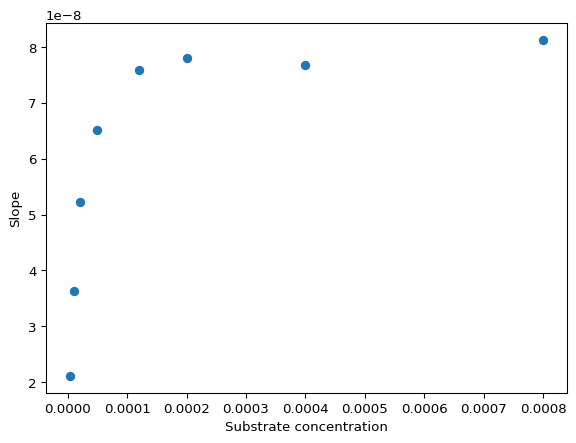

In [140]:
fig, ax = plt.subplots() 

ax.plot(substrate_concentrations, slopes, 'o')
ax.set_xlabel('Substrate concentration')
ax.set_ylabel('Slope')
plt.show()

#### (d) Michaelis Menten

Now that we have the slopes we can fit to the Michaelis Menten equation,
again we need to implement the equation

In [142]:
def mich_menten(S, V_max, K_M):
    return (V_max * S) / (K_M + S)

Then fit to the slopes we extracted

In [144]:
popt, pcov = curve_fit(mich_menten, substrate_concentrations, slopes)
V_max_fit, K_M_fit = popt

print(f'{V_max_fit = :.3e}')
print(f'{K_M_fit = :.3e}')

V_max_fit = 8.122e-08
K_M_fit = 1.104e-05

-   What is the physical meaning of $K_M$ and how does it relate to
    binding affinity?
-   What’s the meaning of $V_{max}$? Why does the curve saturate?

#### (e) Plot with fit

In [146]:
S_smooth = np.linspace(substrate_concentrations.min(), substrate_concentrations.max())
V0_fit = mich_menten(S_smooth, V_max_fit, K_M_fit)

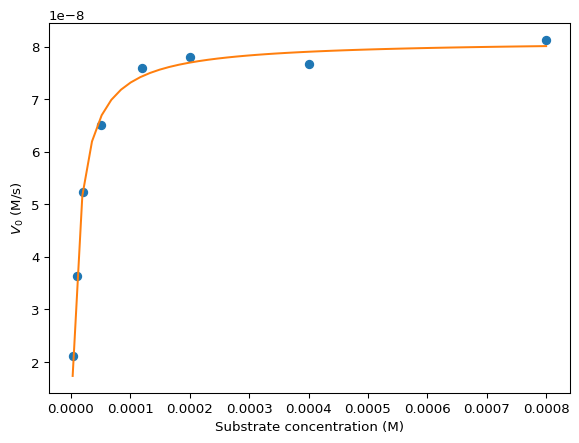

In [148]:
fig, ax = plt.subplots() 

ax.plot(substrate_concentrations, slopes, 'o', label='Data')
ax.plot(S_smooth, V0_fit, label='Fit')

ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel('$V_0$ (M/s)')
plt.show()

#### (f) Turnover number

Given that the enzyme concentration was
$3.33 \frac{\text{mg}}{\text{L}}$ and the molecular weight of the enzyme
(alkaline phosphatase) is 496.6 $\frac{\text{g}}{\text{mol}}$, calculate
the turnover number.

Stary by converting the enzyme concentration to molar units and then
calculate turnover number.

In [150]:
enzyme_conc = (3.33*10**(-3)) / 496.6

kcat = V_max_fit / enzyme_conc

print(f"{kcat = :.3e} 1/s")

kcat = 1.211e-02 1/s

-   What is the biochemical meaning of this number?